In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import os
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from sklearn.naive_bayes import MultinomialNB

In [17]:
#  read the data
#dataset = pd.read_json('News_Category_Dataset_v3.json', lines=True)[['headline','short_description', 'category']]
dataset = pd.read_json('/config/workspace/machine datasets/News_Category_Dataset_v3.json', lines=True)[['headline','short_description', 'category']]
dataset.head()

,headline,short_description,category
0,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for t...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video","He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23),"""Until you have a dog you don't understand what could be eaten.""",COMEDY
3,The Funniest Tweets From Parents This Week (Sept. 17-23),"""Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Ta...",PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer,Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter w...,U.S. NEWS


In [18]:
#Get count for each category
category_count = dataset['category'].value_counts()
print(category_count)
print(f'There are {len(category_count)} categories of news')

category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATI

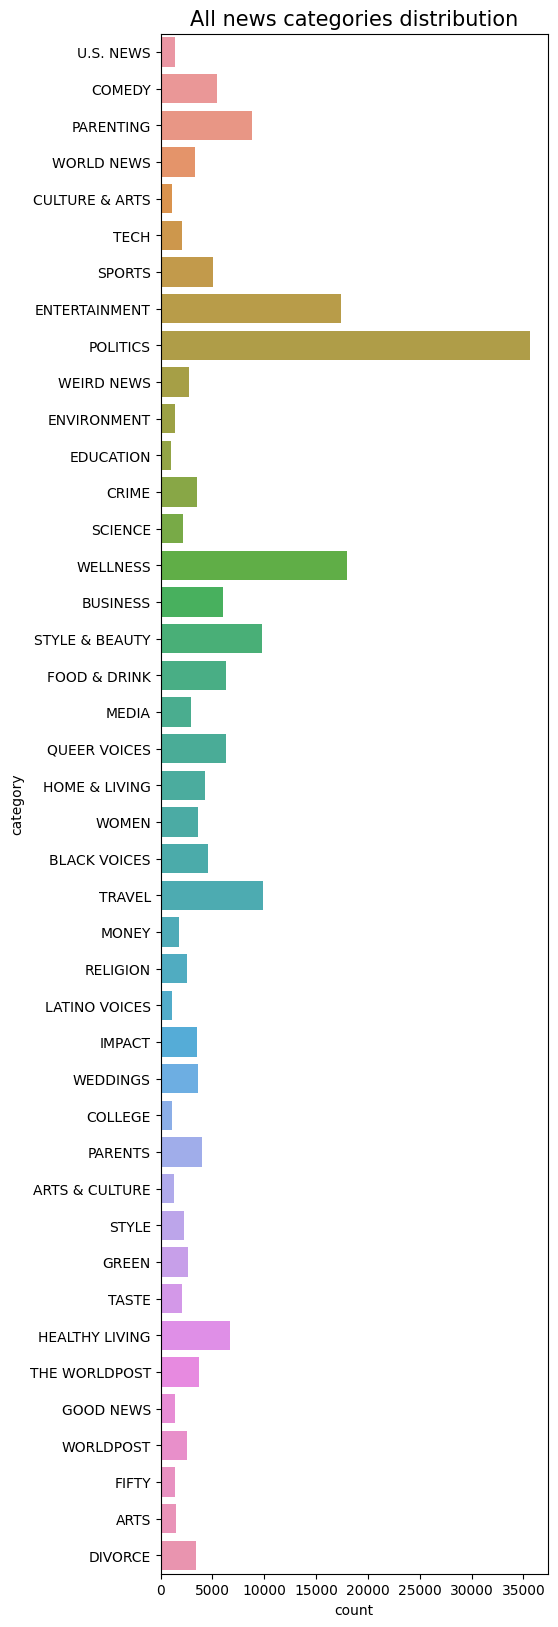

In [19]:
#Plot horizontal category distribution
plt.figure(figsize = [5, 20])
sns.countplot(y=dataset["category"], orient = 'h')
plt.title("All news categories distribution", fontsize = 15)
plt.show()

['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK', 'BUSINESS', 'COMEDY', 'SPORTS', 'BLACK VOICES', 'HOME & LIVING', 'PARENTS']


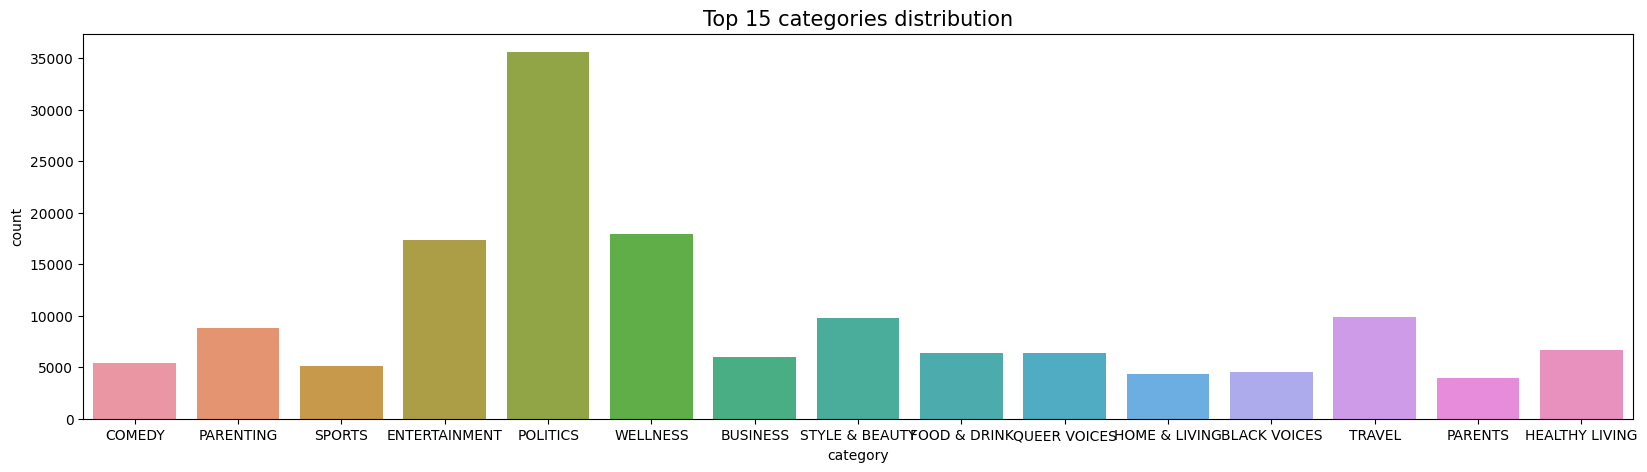

In [20]:
# only top 15 train data counts
top_categories = list(dataset["category"].value_counts().nlargest(15).keys())
print(top_categories)

dataset_top = dataset[dataset['category'].isin(top_categories)]
plt.figure(figsize = [20, 5])
sns.countplot(x=dataset_top["category"])
plt.title("Top 15 categories distribution", fontsize = 15)
plt.show()

In [22]:
# There are around 35000 news in "POLITICS" group, which is the largest group. But most of the groups contain less than 7000 news. In order to solve imbalanced dataset issue, we use upsample technique.

In [23]:
# Upsampling the data
SEED = 42
df_list = []
#Get news in top 15 categories
for i in top_categories:
    df_list.append(pd.DataFrame(dataset_top[dataset_top["category"]==i]))
for i in range(len(df_list)):
    df_list[i] = pd.DataFrame(df_list[i][df_list[i]["short_description"]!=""])
for i in range(len(df_list)):
    df_list[i] = df_list[i].sample(df_list[0].shape[0], replace=True, random_state=SEED)
df_upsample = pd.concat(df_list)
print(df_upsample.shape)

(486615, 3)


In [27]:
#Check 5 samples of short description
df_list[0].short_description.iloc[0:5].to_list()

['Ambivalence about a Trump-Cruz battle pushes many Republican fundraisers away from the presidential contest.',
 "The plan is very hazy, but it's different than what other Republicans have proposed.",
 "MeidasTouch's #GOPBetrayedAmerica spot calls out Republican opposition to a commission to investigate the Jan. 6 insurrection.",
 '"The risks of fracking to our health and to our environment are real," state Attorney General Xavier Becerra says.',
 'Sen. Bernie Sanders claims that in the United States, “almost all of the wealth rests in the hands of the few.” He exaggerates']

In [31]:
#nltk.download('all')
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/config/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [29]:
#Clean the text
df_upsample["text"] = df_upsample["headline"] + " " + df_upsample["short_description"]
df_upsample['text'] = df_upsample['text'].map(lambda x: clean_text(x))
X, y = df_upsample['text'], df_upsample["category"]

NameError: name 'clean_text' is not defined